In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [4]:
latent_dim = 128

class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        return self.deconv(x)
?

In [5]:
class AEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU()
        )
        self.fc = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AEEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

ae = AutoEncoder().to(device)


In [6]:
ae_criterion = nn.MSELoss()
ae_optim = optim.Adam(ae.parameters(), lr=1e-3)

ae_epochs = 10

for ep in range(ae_epochs):
    ae.train()
    total = 0

    for x, _ in train_loader:
        x = x.to(device)

        ae_optim.zero_grad()
        x_hat = ae(x)
        loss = ae_criterion(x_hat, x)
        loss.backward()
        ae_optim.step()

        total += loss.item()

    print(f"AE Epoch [{ep+1}/{ae_epochs}] Loss: {total/len(train_loader):.4f}")


AE Epoch [1/10] Loss: 0.0195
AE Epoch [2/10] Loss: 0.0090
AE Epoch [3/10] Loss: 0.0070
AE Epoch [4/10] Loss: 0.0059
AE Epoch [5/10] Loss: 0.0053
AE Epoch [6/10] Loss: 0.0050
AE Epoch [7/10] Loss: 0.0048
AE Epoch [8/10] Loss: 0.0047
AE Epoch [9/10] Loss: 0.0046
AE Epoch [10/10] Loss: 0.0045


In [7]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

def sample_latent(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class ConvVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAEEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = sample_latent(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

vae = ConvVAE().to(device)


In [8]:
vae_optim = optim.Adam(vae.parameters(), lr=1e-3)
vae_epochs = 15

def vae_loss(x_hat, x, mu, logvar):
    recon = nn.MSELoss()(x_hat, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

for ep in range(vae_epochs):
    vae.train()
    total = 0

    for x, _ in train_loader:
        x = x.to(device)

        vae_optim.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x_hat, x, mu, logvar)
        loss.backward()
        vae_optim.step()

        total += loss.item()

    print(f"VAE Epoch [{ep+1}/{vae_epochs}] Loss: {total/len(train_loader):.4f}")


VAE Epoch [1/15] Loss: 0.0582
VAE Epoch [2/15] Loss: 0.0566
VAE Epoch [3/15] Loss: 0.0562
VAE Epoch [4/15] Loss: 0.0540
VAE Epoch [5/15] Loss: 0.0536
VAE Epoch [6/15] Loss: 0.0536
VAE Epoch [7/15] Loss: 0.0535
VAE Epoch [8/15] Loss: 0.0535
VAE Epoch [9/15] Loss: 0.0535
VAE Epoch [10/15] Loss: 0.0535
VAE Epoch [11/15] Loss: 0.0535
VAE Epoch [12/15] Loss: 0.0534
VAE Epoch [13/15] Loss: 0.0534
VAE Epoch [14/15] Loss: 0.0535
VAE Epoch [15/15] Loss: 0.0534


In [9]:
def show_recon(original, recon, title):
    original = original[:8].cpu()
    recon = recon[:8].cpu()

    plt.figure(figsize=(12, 4))

    for i in range(8):
        plt.subplot(2, 8, i+1)
        plt.imshow(original[i].permute(1,2,0))
        plt.axis("off")

        plt.subplot(2, 8, i+9)
        plt.imshow(recon[i].permute(1,2,0))
        plt.axis("off")

    plt.suptitle(title)
    plt.show()


In [10]:
def recon_metrics(model, loader, is_vae=False):
    model.eval()
    total_loss = 0
    mse = nn.MSELoss()

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)

            if is_vae:
                x_hat, _, _ = model(x)
            else:
                x_hat = model(x)

            total_loss += mse(x_hat, x).item()

    avg_loss = total_loss / len(loader)
    acc = (1 - avg_loss) * 100
    return avg_loss, acc


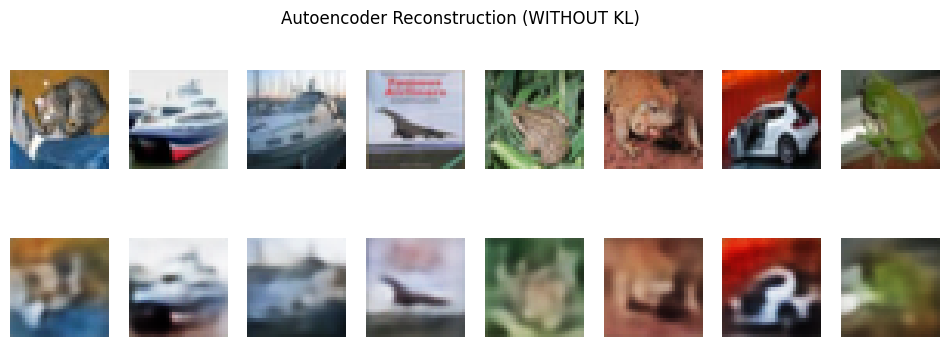

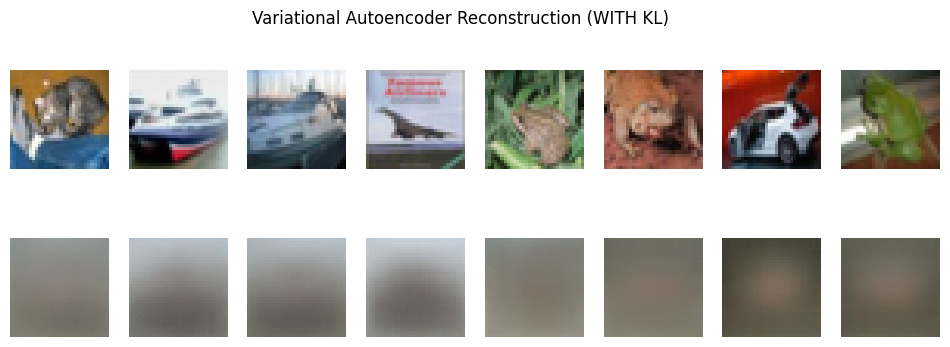

                 Model  Reconstruction Loss  Reconstruction Accuracy (%)
0  Autoencoder (No KL)             0.004559                    99.544080
1        VAE (With KL)             0.045734                    95.426592


In [11]:
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    ae_recon = ae(x)
    vae_recon, _, _ = vae(x)

show_recon(x, ae_recon, "Autoencoder Reconstruction (WITHOUT KL)")
show_recon(x, vae_recon, "Variational Autoencoder Reconstruction (WITH KL)")

loss_ae, acc_ae = recon_metrics(ae, test_loader, is_vae=False)
loss_vae, acc_vae = recon_metrics(vae, test_loader, is_vae=True)

results = pd.DataFrame({
    "Model": ["Autoencoder (No KL)", "VAE (With KL)"],
    "Reconstruction Loss": [loss_ae, loss_vae],
    "Reconstruction Accuracy (%)": [acc_ae, acc_vae]
})

print(results)
